In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Wed Jan 24 12:17:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   33C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.batch_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.const_sigma = True
hp.quantize = False
hp.prior_mu = 0

hp.M = hp.n_prior_embeddings
hp.N = (hp.img_size//4)**2 * hp.batch_size

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma

p_samples1 = torch.randn(hp.M, hp.z_dim).cuda()
p_samples2 = torch.randn(hp.N, hp.z_dim).cuda()
log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

0.030303030303030276


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_normal_noupdate/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if True:
    step, model_list, optimizer_list = load_model_list(save_dir, 7949, model_list, optimizer_list)

total 16108
-rw-rw-r-- 1 scpark scpark       0  1월 24 12:18 events.out.tfevents.1706066315.GPUSVR11
-rw-rw-r-- 1 scpark scpark 1160204  1월 24 12:17 events.out.tfevents.1706065481.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7477253  1월 24 12:17 save_7949
-rw-rw-r-- 1 scpark scpark 7470716  1월 24 12:05 save_0
-rw-rw-r-- 1 scpark scpark  373702  1월 24 12:02 events.out.tfevents.1706065011.GPUSVR11
-rw-rw-r-- 1 scpark scpark    2894  1월 24 11:56 events.out.tfevents.1706064970.GPUSVR11


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

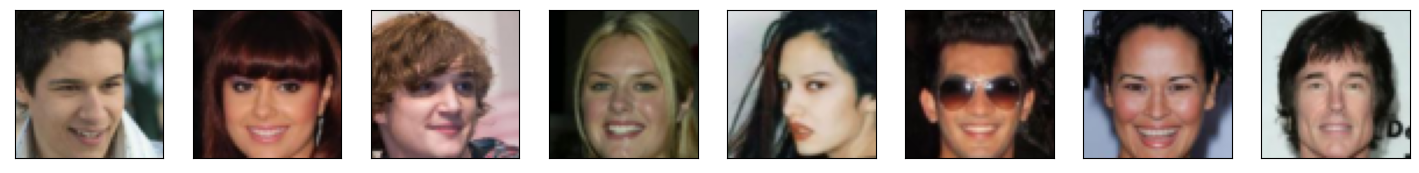

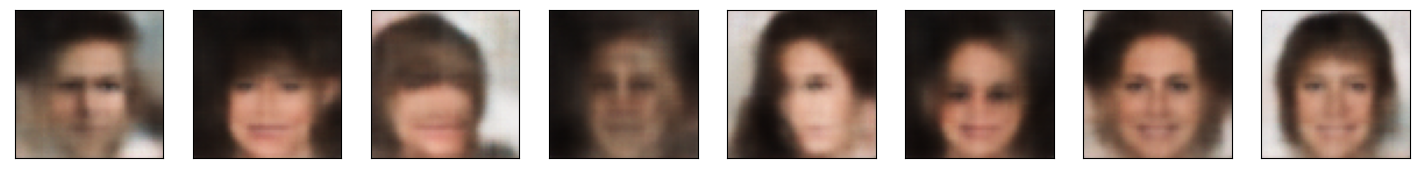

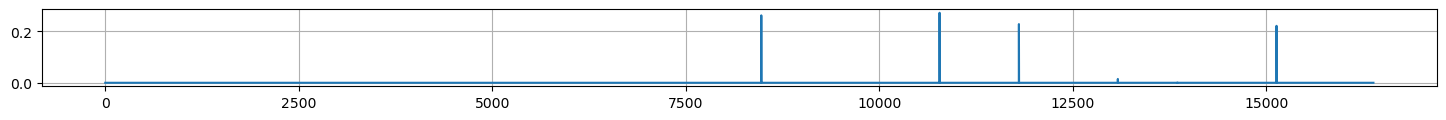

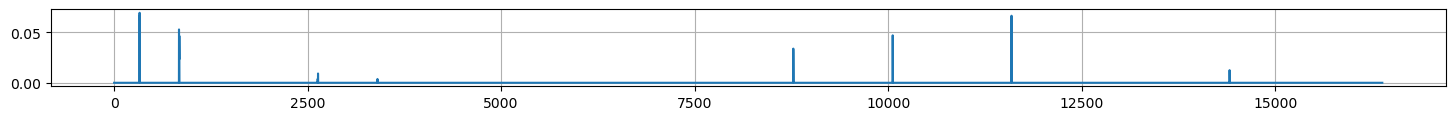

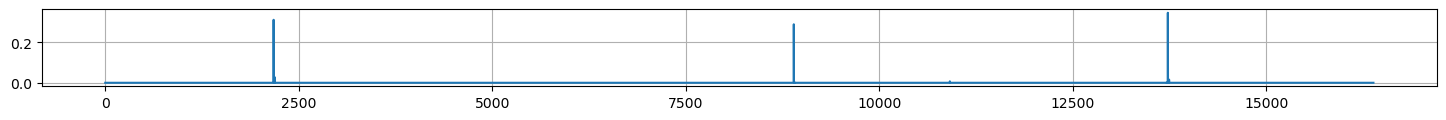

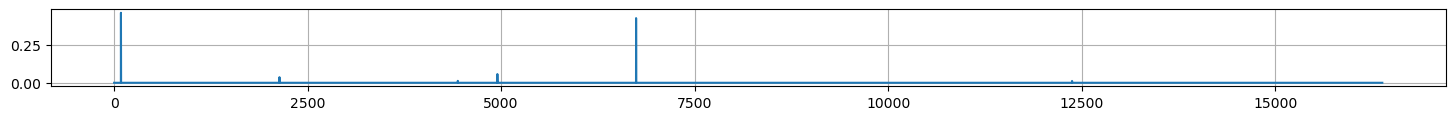

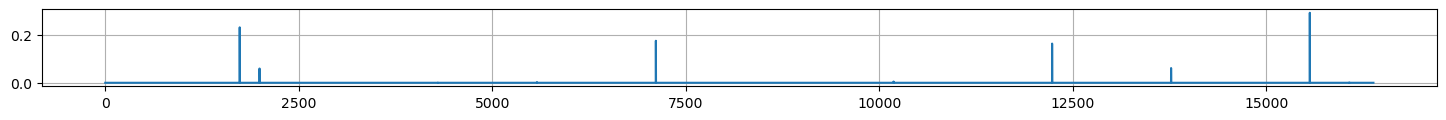

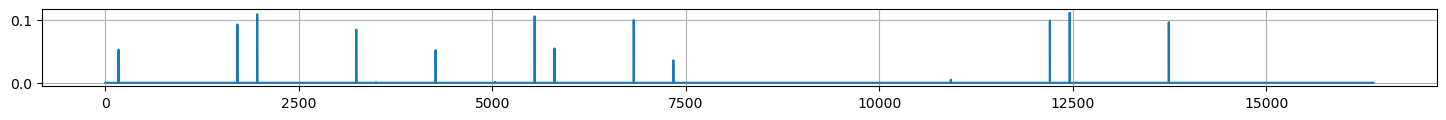

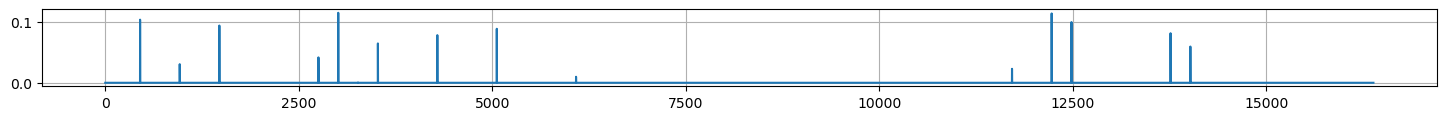

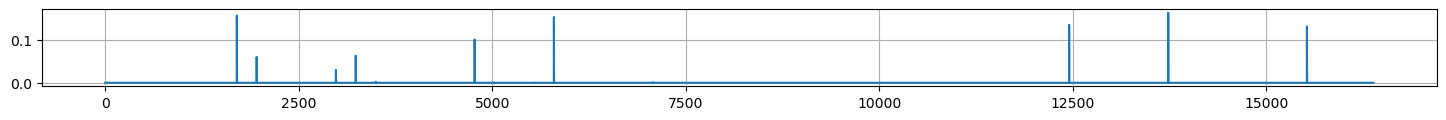

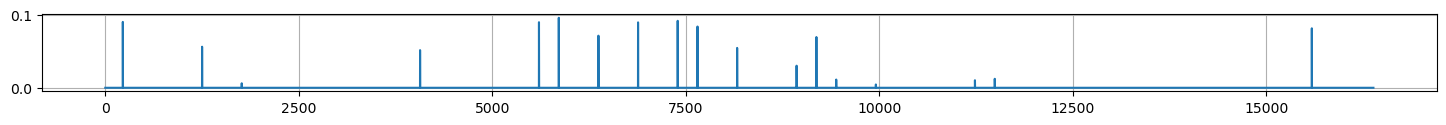

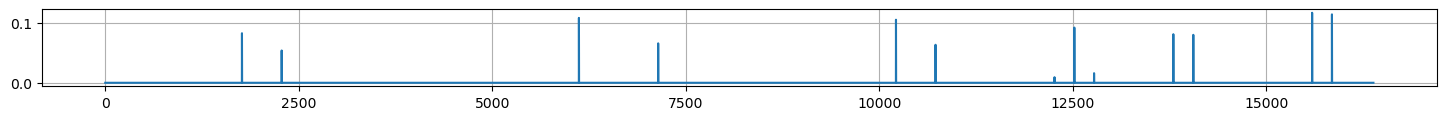

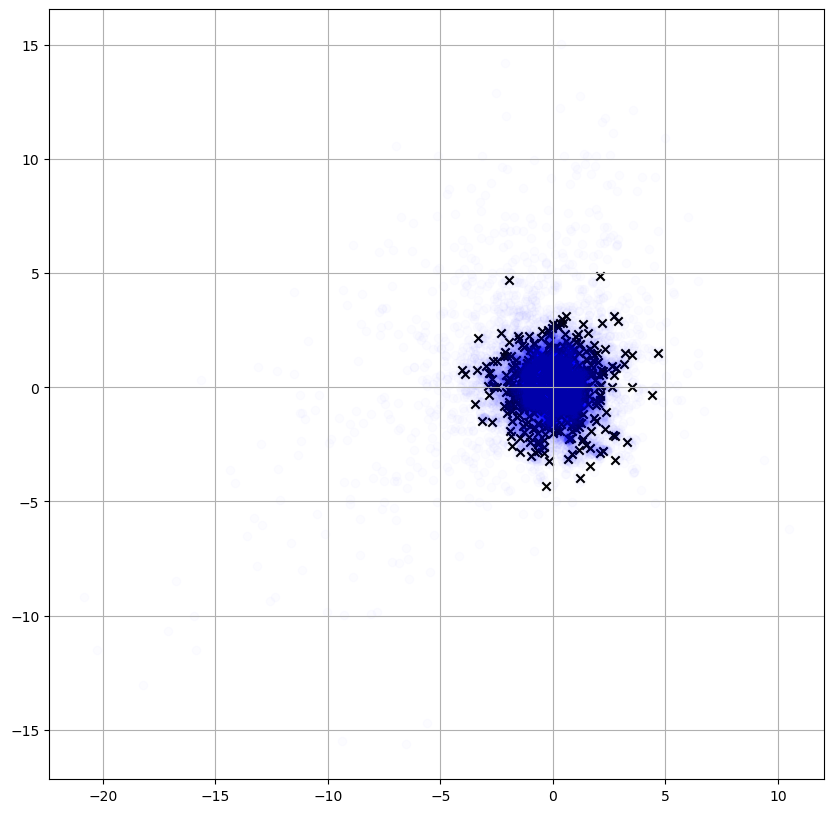

19001
lse_loss -21.295562744140625
commit_loss 1.2853631973266602
recon_loss 0.016516439616680145
19002
lse_loss -21.485572814941406
commit_loss 1.247793436050415
recon_loss 0.015197750180959702
19003
lse_loss -21.546035766601562
commit_loss 1.254703164100647
recon_loss 0.01502113789319992
19004
lse_loss -21.524444580078125
commit_loss 1.2344703674316406
recon_loss 0.016951680183410645
19005
lse_loss -21.419387817382812
commit_loss 1.2681922912597656
recon_loss 0.01608714833855629
19006
lse_loss -21.431854248046875
commit_loss 1.240862488746643
recon_loss 0.015206046402454376
19007
lse_loss -21.381004333496094
commit_loss 1.2772008180618286
recon_loss 0.015431120991706848
19008
lse_loss -21.37853240966797
commit_loss 1.2667770385742188
recon_loss 0.014352215453982353
19009
lse_loss -21.45708465576172
commit_loss 1.2832874059677124
recon_loss 0.016549378633499146
19010
lse_loss -21.385093688964844
commit_loss 1.2734864950180054
recon_loss 0.016758956015110016
19011
lse_loss -21.31248474

lse_loss -21.464298248291016
commit_loss 1.2564910650253296
recon_loss 0.015137488022446632
19088
lse_loss -21.428543090820312
commit_loss 1.2489482164382935
recon_loss 0.015779919922351837
19089
lse_loss -21.409690856933594
commit_loss 1.2966716289520264
recon_loss 0.01533737313002348
19090
lse_loss -21.30617904663086
commit_loss 1.2506890296936035
recon_loss 0.013530947268009186
19091
lse_loss -21.457969665527344
commit_loss 1.2632375955581665
recon_loss 0.015371635556221008
19092
lse_loss -21.46764373779297
commit_loss 1.2768880128860474
recon_loss 0.014714499935507774
19093
lse_loss -21.455432891845703
commit_loss 1.2819479703903198
recon_loss 0.014695021323859692
19094
lse_loss -21.305572509765625
commit_loss 1.299826741218567
recon_loss 0.01603212207555771
19095
lse_loss -21.405029296875
commit_loss 1.252671718597412
recon_loss 0.01471034251153469
19096
lse_loss -21.380287170410156
commit_loss 1.2793177366256714
recon_loss 0.015358701348304749
19097
lse_loss -21.443462371826172
c

lse_loss -21.474220275878906
commit_loss 1.2540736198425293
recon_loss 0.016830556094646454
19174
lse_loss -21.524433135986328
commit_loss 1.2591278553009033
recon_loss 0.017275914549827576
19175
lse_loss -21.415252685546875
commit_loss 1.2668137550354004
recon_loss 0.015869710594415665
19176
lse_loss -21.52843475341797
commit_loss 1.2462098598480225
recon_loss 0.016554977744817734
19177
lse_loss -21.417213439941406
commit_loss 1.2278292179107666
recon_loss 0.014865919947624207
19178
lse_loss -21.45132827758789
commit_loss 1.2496826648712158
recon_loss 0.016791269183158875
19179
lse_loss -21.484378814697266
commit_loss 1.2608134746551514
recon_loss 0.016460563987493515
19180
lse_loss -21.475196838378906
commit_loss 1.270359754562378
recon_loss 0.015403037890791893
19181
lse_loss -21.337085723876953
commit_loss 1.289969801902771
recon_loss 0.017217174172401428
19182
lse_loss -21.282928466796875
commit_loss 1.2568408250808716
recon_loss 0.014114154502749443
19183
lse_loss -21.40116882324

19260
lse_loss -21.318153381347656
commit_loss 1.2697782516479492
recon_loss 0.015239882282912731
19261
lse_loss -21.55093002319336
commit_loss 1.2727105617523193
recon_loss 0.016236253082752228
19262
lse_loss -21.48769760131836
commit_loss 1.2784826755523682
recon_loss 0.01605634018778801
19263
lse_loss -21.48178482055664
commit_loss 1.2883750200271606
recon_loss 0.017288126051425934
19264
lse_loss -21.398632049560547
commit_loss 1.2839035987854004
recon_loss 0.016451416537165642
19265
lse_loss -21.543071746826172
commit_loss 1.2692999839782715
recon_loss 0.014534725807607174
19266
lse_loss -21.448169708251953
commit_loss 1.2504847049713135
recon_loss 0.01594308391213417
19267
lse_loss -21.560882568359375
commit_loss 1.2805516719818115
recon_loss 0.014466586522758007
19268
lse_loss -21.33037567138672
commit_loss 1.2710397243499756
recon_loss 0.015599163249135017
19269
lse_loss -21.369674682617188
commit_loss 1.2640330791473389
recon_loss 0.01758129894733429
19270
lse_loss -21.53284072

19347
lse_loss -21.552268981933594
commit_loss 1.26116943359375
recon_loss 0.015564806759357452
19348
lse_loss -21.527862548828125
commit_loss 1.2852461338043213
recon_loss 0.015227427706122398
19349
lse_loss -21.46656036376953
commit_loss 1.2591813802719116
recon_loss 0.01642894558608532
19350
lse_loss -21.466201782226562
commit_loss 1.2605211734771729
recon_loss 0.014764916151762009
19351
lse_loss -21.567832946777344
commit_loss 1.260179042816162
recon_loss 0.01640721783041954
19352
lse_loss -21.428573608398438
commit_loss 1.2523317337036133
recon_loss 0.015395617112517357
19353
lse_loss -21.22565460205078
commit_loss 1.2651565074920654
recon_loss 0.016875039786100388
19354
lse_loss -21.514862060546875
commit_loss 1.263444423675537
recon_loss 0.015611289069056511
19355
lse_loss -21.40267562866211
commit_loss 1.2936304807662964
recon_loss 0.01639959029853344
19356
lse_loss -21.434913635253906
commit_loss 1.2953259944915771
recon_loss 0.016514508053660393
19357
lse_loss -21.35624313354

19433
lse_loss -21.407001495361328
commit_loss 1.3049622774124146
recon_loss 0.017987273633480072
19434
lse_loss -21.27941131591797
commit_loss 1.2838728427886963
recon_loss 0.014683961868286133
19435
lse_loss -21.428314208984375
commit_loss 1.260628581047058
recon_loss 0.017408112064003944
19436
lse_loss -21.58563995361328
commit_loss 1.257866382598877
recon_loss 0.015093028545379639
19437
lse_loss -21.352745056152344
commit_loss 1.2609487771987915
recon_loss 0.015974078327417374
19438
lse_loss -21.42667007446289
commit_loss 1.2929519414901733
recon_loss 0.017084939405322075
19439
lse_loss -21.37531280517578
commit_loss 1.2577165365219116
recon_loss 0.016022639349102974
19440
lse_loss -21.443965911865234
commit_loss 1.2605468034744263
recon_loss 0.015871424227952957
19441
lse_loss -21.52291488647461
commit_loss 1.319501280784607
recon_loss 0.01508843433111906
19442
lse_loss -21.37386703491211
commit_loss 1.2757189273834229
recon_loss 0.01398472860455513
19443
lse_loss -21.403659820556

19519
lse_loss -21.41730499267578
commit_loss 1.2859010696411133
recon_loss 0.0169297493994236
19520
lse_loss -21.420608520507812
commit_loss 1.268369197845459
recon_loss 0.01693633198738098
19521
lse_loss -21.277210235595703
commit_loss 1.2468845844268799
recon_loss 0.015505742281675339
19522
lse_loss -21.388805389404297
commit_loss 1.2953100204467773
recon_loss 0.015982933342456818
19523
lse_loss -21.361225128173828
commit_loss 1.2639168500900269
recon_loss 0.01825704239308834
19524
lse_loss -21.5115966796875
commit_loss 1.2570571899414062
recon_loss 0.015511158853769302
19525
lse_loss -21.42330551147461
commit_loss 1.3058453798294067
recon_loss 0.01607084646821022
19526
lse_loss -21.602005004882812
commit_loss 1.2972335815429688
recon_loss 0.016795668751001358
19527
lse_loss -21.393917083740234
commit_loss 1.266120433807373
recon_loss 0.01687757298350334
19528
lse_loss -21.457927703857422
commit_loss 1.287774920463562
recon_loss 0.015550854615867138
19529
lse_loss -21.30585098266601

19604
lse_loss -21.449825286865234
commit_loss 1.2596828937530518
recon_loss 0.016681574285030365
19605
lse_loss -21.425514221191406
commit_loss 1.2771700620651245
recon_loss 0.014700157567858696
19606
lse_loss -21.468090057373047
commit_loss 1.2888867855072021
recon_loss 0.015220506116747856
19607
lse_loss -21.396018981933594
commit_loss 1.283033847808838
recon_loss 0.01607738807797432
19608
lse_loss -21.51004409790039
commit_loss 1.255631685256958
recon_loss 0.014266964048147202
19609
lse_loss -21.328731536865234
commit_loss 1.2743762731552124
recon_loss 0.01682303473353386
19610
lse_loss -21.334308624267578
commit_loss 1.2866665124893188
recon_loss 0.01570930704474449
19611
lse_loss -21.416797637939453
commit_loss 1.289001703262329
recon_loss 0.01768367551267147
19612
lse_loss -21.471221923828125
commit_loss 1.2652360200881958
recon_loss 0.015030253678560257
19613
lse_loss -21.51305389404297
commit_loss 1.2650108337402344
recon_loss 0.01538010686635971
19614
lse_loss -21.43022918701

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)
            
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')